In [22]:
import sys
sys.path.append("../src/")
import integration as itg
import mittag_leffler as ml
import utils as ut
import matplotlib.pyplot as plt
plt.style.use("../src/plot_style.mplstyle")
import numpy as np

data_path = "../data/"

# Fractional Langevin equation

Particle accelerated by the effect of a random force and a fractional dissipative term
 
$$
M\frac{d^2 q(t)}{dt^2} + M \eta_0 D^{\beta}_t q(t) = \xi(t)
$$

Using the Laplace tranform, it is obtained the following set of solutions:

$$
q(t) = \frac{1}{M} [ f(t) \ast t E_{2-\beta, 2}\left( -\eta_0 t^{2-\beta} \right)\\ + Mq'(0) E_{2-\beta, 2}\left( -\eta_0 t^{2-\beta} \right)\\ + Mq(0) E_{2-\beta, 1}\left( -\eta_0 t^{2-\beta} \right)\\ + b_0(t)]
$$

In [23]:
def line(t):
    return t

def solution_sde(t, noise, x0, v0):
    t_ = np.array(t)
    noise_ = np.array(noise)
    return x0 + v0*t_ + itg.convolution(line, noise_, t_)

In [24]:
def solution_fle_white(t, noise, order, v0):
	t__ = np.array(t)
	noise__ = np.array(noise)
	def nonlinear_term(t):
		z = -t**(2-order)
		return t * ml.mittag_leffler_vector(z, 2-order, 2)
	conv = itg.convolution(nonlinear_term, noise__, t__)
	nonlinear = v0 * nonlinear_term(t__)
	return nonlinear + conv

In [25]:
final_time = 30
noise_steps = 1
x0 = 0
v0 = 0

In [38]:
def plot_results(h, time, axi, panel, percentage = 1, xlabel = False, ylabel = True):
    fd_order = 2 - 2*h
    final_time = 30

    df_ns1 = ut.read_hdf5_data(data_path + f"fle-h-{h}-noise{time}.hdf5")
    df_sol1 = ut.read_hdf5_data(data_path + f"fle-h-{h}-{time}-v00.hdf5")
    N = len(df_ns1)
    delta_t = final_time/N
    t = df_ns1.deets_t
    noise = df_ns1.deets_v
    fg = solution_sde(t, noise, x0, v0)
    anl = solution_fle_white(t, noise, fd_order, fg[2]/delta_t)
    t_sol = df_sol1.deets_t
    sol = df_sol1.deets_v
    N = int(percentage*len(sol))
    
    axi.plot(t_sol[:N], sol[:N], marker = "^", ls = "", label = "Numerical")
    axi.plot(t[:N], anl[:N], label = "Analytical")
    if ylabel:
        axi.set_ylabel(r"$q(t)$")
    if xlabel:
        axi.set_xlabel(r"$t$")
    axi.set_title(panel)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
    axi.text(0.05, 0.15, f"H = {h}", transform=axi.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

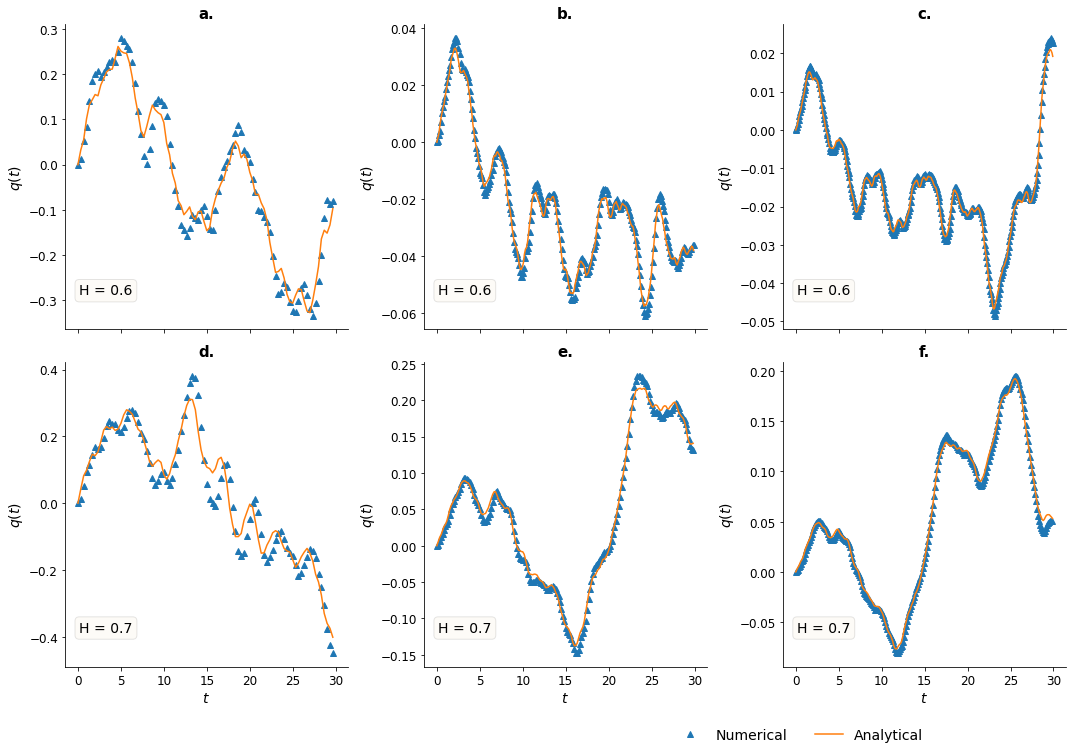

In [42]:
fig, ax = plt.subplots(2,3, figsize = (15, 10), sharex = True)

times = [90, 250, 350]
h = 0.6
axi = ax[0][0]
plot_results(h, times[0], axi, panel="a.", ylabel = True)
axi = ax[0][1]
plot_results(h, times[1], axi, panel="b.", ylabel = True)
axi = ax[0][2]
plot_results(h, times[2], axi, panel="c.", ylabel = True)

h = 0.7
times = [90, 180, 250]
axi = ax[1][0]
plot_results(h, times[0], axi, panel="d.", ylabel = True, xlabel = True)
axi = ax[1][1]
plot_results(h, times[1], axi, panel="e.", ylabel = True, xlabel = True)
axi = ax[1][2]
plot_results(h, times[2], axi, panel="f.", ylabel = True, xlabel = True)

handles, labels = ax[0][0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor = (0.87, 0.0), ncol = 3)
fig.tight_layout()
